In [3]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [4]:
start_day_to_analyze = '2020-05-12'
end_day_to_analyze = '2020-05-13'

In [5]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [6]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [7]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [8]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [9]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,3139,552,ALT,buy,728,3.72,"{'avg': 3.5794, 'rsi': 63.22396715869297, 'mac...",2020-05-12 15:35:13.920947+00:00,2020-05-12 15:35:14.290413,3.59,4.11
1,3157,552,ALT,sell,728,3.74,{'liquidation': 1},2020-05-12 19:45:15.913422+00:00,2020-05-12 19:45:16.368439,3.59,4.11
2,3130,552,ASTC,buy,383,3.09,"{'avg': 2.9935, 'rsi': 65.83427788715449, 'mac...",2020-05-12 13:51:04.921894+00:00,2020-05-12 13:51:05.009314,2.85,3.84
3,3131,552,ASTC,sell,191,3.16,"{'avg': 3.0467, 'rsi': [65.40073886973566, 66....",2020-05-12 13:55:21.631093+00:00,2020-05-12 13:55:21.756971,2.85,3.84
4,3132,552,ASTC,sell,96,3.24,"{'avg': 3.0734, 'rsi': [65.40073886973566, 71....",2020-05-12 13:55:46.506826+00:00,2020-05-12 13:55:46.776344,2.85,3.84
5,3133,552,ASTC,sell,48,3.40,"{'avg': 3.1355, 'rsi': [74.11097661349174, 76....",2020-05-12 13:56:36.320093+00:00,2020-05-12 13:56:36.454904,2.85,3.84
6,3134,552,ASTC,sell,48,3.47,"{'avg': 3.1481, 'rsi': [74.11097661349174, 79....",2020-05-12 13:56:38.377556+00:00,2020-05-12 13:56:38.605771,2.85,3.84
7,3135,552,MGY,buy,412,5.49,"{'avg': 5.4114, 'rsi': 59.55970238823301, 'mac...",2020-05-12 14:32:08.384440+00:00,2020-05-12 14:32:08.630235,5.27,6.19
8,3140,552,MGY,sell,412,5.25,"{'avg': 5.4062, 'rsi': [41.21374087289977, 37....",2020-05-12 15:36:28.430803+00:00,2020-05-12 15:36:28.589043,5.27,6.19
9,3136,552,NLS,buy,862,6.14,"{'avg': 6.0164, 'rsi': 66.79514342650755, 'mac...",2020-05-12 15:07:56.094602+00:00,2020-05-12 15:07:56.936618,6.03,6.48


In [10]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [11]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [12]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,552,momentum_long,PAPER,v0.1-377-g7f1cc98,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 180}",2020-05-12 13:45:01.280585,2020-05-12 20:10:00.673655,market close


,symbol,count,revenue
1,SNES,4,-271.26
5,VOD,2,-99.40
9,MGY,2,-98.88
4,NLS,2,-94.82
3,UNIT,2,-88.80
6,SAR,2,0.00
7,ALT,2,14.56
2,OSTK,3,32.24
10,SSRM,2,33.75
0,ASTC,5,60.89


TOTAL REVENUE: -421.92 $


In [13]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [14]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].between_time("9:30", "16:00").dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

ASTC analysis for run 552 with profit 60.89


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1183.47,-1183.47,buy,2020-05-12 13:51:05.009314,3.09,"[2.88, 2.89]",[3.13],383,"{'avg': 2.9935, 'rsi': 65.83427788715449, 'macd': [0.03776897037361859, 0.040395562589463196, 0.03959992329886308, 0.040918440398263645, 0.04526635618385377], 'vwap': 3.0974, 'supports': [2.7835, 2.83, 2.86, 2.91, 2.91, 2.92, 3.09], 'sell_macd': [0.024287848381500776, 0.02581758693967018, 0.025115856115650814, 0.02580131448504286, 0.02846269354580233], 'slow macd': [-0.006025935439546881, -0.003962361698875316, -0.002537278682449351, -0.0007422906234624271, 0.001668439758873319], 'macd_signal': [0.026622807149337097, 0.029377358237362317, 0.03142187124966247, 0.033321185079382705, 0.035710219300276916], 'resistances': [3.1333, 3.17, 3.1799, 3.21], 'position_ratio': '4.85', 'sell_macd_signal': [0.017649558758569214, 0.019283164394789408, 0.02044970273896169, 0.021520025088177925, 0.022908558779702805]}",3.84,2.85
1,-579.91,603.56,sell,2020-05-12 13:55:21.756971,3.16,None,None,191,"{'avg': 3.0467, 'rsi': [65.40073886973566, 66.60456741764351], 'vwap': 3.1601, 'reasons': 'scale-out', 'movement': 0.022653721682847988, 'sell_macd': [0.028440892880880586, 0.03198100625180933, 0.03432419840770429, 0.03593286504336657, 0.037530100538124334], 'sell_macd_signal': [0.024168791833704538, 0.025731234717325496, 0.027449827455401254, 0.029146434972994316, 0.03082316808602032]}",3.84,2.85
2,-268.87,311.04,sell,2020-05-12 13:55:46.776344,3.24,None,None,96,"{'avg': 3.0734, 'rsi': [65.40073886973566, 71.11433019507655], 'vwap': 3.2274, 'reasons': 'scale-out', 'movement': 0.022151898734177163, 'sell_macd': [0.028440892880880586, 0.03198100625180933, 0.03432419840770429, 0.03593286504336657, 0.041166464174488215], 'sell_macd_signal': [0.024168791833704538, 0.025731234717325496, 0.027449827455401254, 0.029146434972994316, 0.0315504408132931]}",3.84,2.85
3,-105.67,163.20,sell,2020-05-12 13:56:36.454904,3.40,None,None,48,"{'avg': 3.1355, 'rsi': [74.11097661349174, 76.71267715576268], 'vwap': 3.3383, 'reasons': 'scale-out', 'movement': 0.033950617283950574, 'sell_macd': [0.03198100625180933, 0.03432419840770429, 0.03593286504336657, 0.04428334729137129, 0.05333199128603239], 'sell_macd_signal': [0.025731234717325496, 0.027449827455401254, 0.029146434972994316, 0.03217381743666971, 0.036405452206542246]}",3.84,2.85
4,60.89,166.56,sell,2020-05-12 13:56:38.605771,3.47,None,None,48,"{'avg': 3.1481, 'rsi': [74.11097661349174, 79.2497689790797], 'vwap': 3.3998, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.00676470588235298, 'sell_macd': [0.03198100625180933, 0.03432419840770429, 0.03593286504336657, 0.04428334729137129, 0.05712419907824051], 'sell_macd_signal': [0.025731234717325496, 0.027449827455401254, 0.029146434972994316, 0.03217381743666971, 0.03716389376498387]}",3.84,2.85


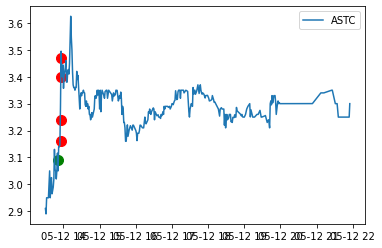

SNES analysis for run 552 with profit -271.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3326.40,-3326.40,buy,2020-05-12 15:15:23.185216,2.80,"[2.6988, 2.7401, 2.75]","[2.8345, 2.9]",1188,"{'avg': 2.822, 'rsi': 55.34274782248894, 'macd': [0.0036163170257723642, 0.006086460581961273, 0.006779747293141014, 0.007644518963801694, 0.008625812791654752], 'vwap': 2.8114, 'supports': [2.5405, 2.6319, 2.6988, 2.7401, 2.75, 2.75, 2.8], 'sell_macd': [0.0032364927962409418, 0.004777518724933039, 0.005152636088525231, 0.00563775824082402, 0.006197103317409969], 'slow macd': [0.001386753707022681, 0.0018899168562152013, 0.0021147144327318124, 0.002398121216351967, 0.0027333977154495592], 'macd_signal': [-0.003949745298861609, -0.0019425041226970325, -0.0001980538395294231, 0.0013704607211368004, 0.002821531135240391], 'resistances': [2.8345, 2.9, 3.0699], 'position_ratio': '2.48', 'sell_macd_signal': [-0.0015735447911400925, -0.0003033320879254663, 0.0007878615473646733, 0.0017578408860565427, 0.0026456933723272283]}",3.05,2.73
1,-142.56,3183.84,sell,2020-05-12 15:36:43.469698,2.68,None,None,1188,"{'avg': 2.8201, 'rsi': [45.30107687568617, 31.990725530290604], 'vwap': 2.7109, 'reasons': 'stopped', 'movement': -0.04285714285714274, 'sell_macd': [-0.0026230161323494983, -0.001858115171874175, -0.0012379570835574505, -0.0020996786110565324, -0.00709712813104213], 'sell_macd_signal': [-4.306062008647548e-05, -0.00040607153044401546, -0.0005724486410667025, -0.0008778946350646685, -0.002121741334260161]}",3.05,2.73
2,-4160.86,-4018.30,buy,2020-05-12 16:00:34.373729,2.81,"[2.68, 2.7561, 2.7588]","[2.82, 2.85]",1430,"{'avg': 2.8137, 'rsi': 55.270711863351195, 'macd': [0.0004488833542368731, 0.00035492354034705187, 0.0034761239876939243, 0.0050841742072655904, 0.00628610330570778], 'vwap': 2.7977, 'supports': [2.6319, 2.68, 2.6988, 2.7401, 2.75, 2.7561, 2.7588, 2.8], 'sell_macd': [0.0002766748590028456, 0.00020494377556223853, 0.002229504700471896, 0.003258649515979428, 0.004018260417466113], 'slow macd': [0.00016361358574989993, 0.000154280208245261, 0.0007867899153741753, 0.0012075246920404403, 0.0015926828777024227], 'macd_signal': [0.003243399299308984, 0.0026657041475165975, 0.002827788115552063, 0.0032790653338947684, 0.0038804729282573705], 'resistances': [2.82, 2.82, 2.8345, 2.85, 2.9, 3.0699], 'position_ratio': '1.0', 'sell_macd_signal': [0.002210355078914727, 0.0018092728182442293, 0.0018933191946897627, 0.0021663852589476956, 0.002536760290651379]}",3.01,2.74
3,-271.26,3889.60,sell,2020-05-12 16:13:46.662306,2.72,None,None,1430,"{'avg': 2.8135, 'rsi': [49.202938245588044, 38.56480108820612], 'vwap': 2.7372, 'reasons': 'stopped', 'movement': -0.032028469750889625, 'sell_macd': [0.0008859316908420567, -0.000597931186758327, -0.00039057847856671657, -0.0005460104140206923, -0.0037769182804261447], 'sell_macd_signal': [0.002292275406880359, 0.0017142340881526217, 0.0012932715748087541, 0.0009254151770428648, -1.505151445093712e-05]}",3.01,2.74


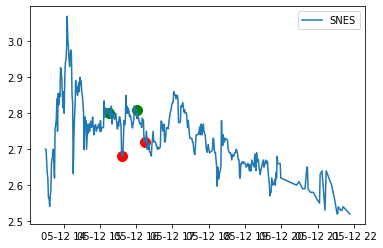

OSTK analysis for run 552 with profit 32.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1387.44,-1387.44,buy,2020-05-12 16:02:56.215415,19.27,"[18.932, 19.2345]",[19.3764],72,"{'avg': 18.5463, 'rsi': 61.16706580659043, 'macd': [-0.009638831262325454, -0.002184446586518618, 0.004821518006622227, 0.011962698038210817, 0.020500514894433053], 'vwap': 19.28, 'supports': [18.2129, 18.3, 18.932, 19.2345], 'sell_macd': [-0.008852783892919547, -0.003702320133207593, 0.0011019674734917828, 0.00594294525178185, 0.011643149426404875], 'slow macd': [0.07658994348073378, 0.075711704326892, 0.07501131443872566, 0.07458922631780496, 0.07469894975982427], 'macd_signal': [-0.016653883403525367, -0.013759996040124017, -0.010043693230774767, -0.00564241497697765, -0.00041382900269550885], 'resistances': [19.3764], 'position_ratio': '2.12', 'sell_macd_signal': [-0.015137643372456771, -0.012850578724606935, -0.01006006948498719, -0.006859466537633382, -0.00315894334482573]}",20.42,18.9
1,-4778.96,-3391.52,buy,2020-05-12 16:02:56.324361,19.27,"[18.932, 19.2345]",[19.3764],176,"{'avg': 18.5463, 'rsi': 61.16706580659043, 'macd': [-0.009638831262325454, -0.002184446586518618, 0.004821518006622227, 0.011962698038210817, 0.020500514894433053], 'vwap': 19.28, 'supports': [18.2129, 18.3, 18.932, 19.2345], 'sell_macd': [-0.008852783892919547, -0.003702320133207593, 0.0011019674734917828, 0.00594294525178185, 0.011643149426404875], 'slow macd': [0.07658994348073378, 0.075711704326892, 0.07501131443872566, 0.07458922631780496, 0.07469894975982427], 'macd_signal': [-0.016653883403525367, -0.013759996040124017, -0.010043693230774767, -0.00564241497697765, -0.00041382900269550885], 'resistances': [19.3764], 'position_ratio': '2.12', 'sell_macd_signal': [-0.015137643372456771, -0.012850578724606935, -0.01006006948498719, -0.006859466537633382, -0.00315894334482573]}",20.42,18.9
2,32.24,4811.20,sell,2020-05-12 16:23:17.770936,19.40,None,None,248,"{'avg': 18.601, 'rsi': [56.36224027022381, 56.362240270223815], 'vwap': 19.3902, 'reasons': 'bail', 'movement': 0.006227296315516399, 'sell_macd': [0.04626671077631883, 0.04530053824957392, 0.04524766955016801, 0.04177208784218678, 0.03852134770814786], 'sell_macd_signal': [0.0348898553696284, 0.036971991945617504, 0.038627127466527605, 0.03925611954165944, 0.03910916517495712]}",20.42,18.9


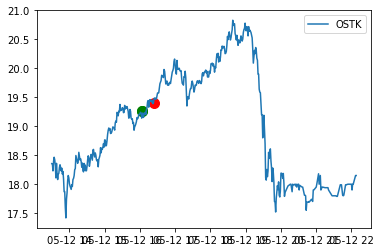

UNIT analysis for run 552 with profit -88.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5155.95,-5155.95,buy,2020-05-12 16:15:29.728430,9.29,"[9.135, 9.18]",[9.389],555,"{'avg': 8.9013, 'rsi': 61.56228447894257, 'macd': [-0.011250493656822513, -0.009378036538576495, -0.0030178147332442506, 0.0035791432593459405, 0.008722866549730313], 'vwap': 9.29, 'supports': [8.73, 8.84, 8.93, 8.9501, 9.0342, 9.135, 9.18], 'sell_macd': [-0.007890111924233167, -0.006553478964882231, -0.0023099535554553796, 0.0020552604461165913, 0.00544042381817178], 'slow macd': [0.030576515078170274, 0.02969224502609613, 0.029790815849793262, 0.030150531244407475, 0.030436458072887973], 'macd_signal': [-0.010204208408219789, -0.01003897403429113, -0.008634742174081753, -0.006191965087396214, -0.0032089987599709085], 'resistances': [9.389], 'position_ratio': '0.9', 'sell_macd_signal': [-0.007829565993533238, -0.007574348587803037, -0.006521469581333506, -0.004806123575843486, -0.002756814097040433]}",9.8,9.12
1,-88.80,5067.15,sell,2020-05-12 16:34:37.656277,9.13,None,None,555,"{'avg': 8.9302, 'rsi': [37.87484258782967, 34.013779370450806], 'vwap': 9.12, 'reasons': 'stopped', 'movement': -0.018299246501614633, 'sell_macd': [0.004046268763147509, 0.0027974895120053134, -0.000549578599429168, -0.004708987795359221, -0.009707112002638851], 'sell_macd_signal': [0.0039140392717290015, 0.003690729319784264, 0.0028426677359415778, 0.001332336629681418, -0.000875553096782636]}",9.8,9.12


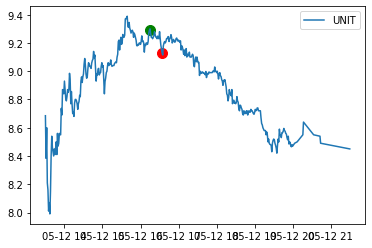

NLS analysis for run 552 with profit -94.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5292.68,-5292.68,buy,2020-05-12 15:07:56.936618,6.14,"[5.95, 6.03, 6.05]",[6.17],862,"{'avg': 6.0164, 'rsi': 66.79514342650755, 'macd': [0.008589484494103239, 0.010695401161397555, 0.01262231135758185, 0.014785875626870393, 0.01711019662842883], 'vwap': 6.1492, 'supports': [5.9101, 5.95, 6.03, 6.05], 'sell_macd': [0.004688444110945156, 0.006081810566006318, 0.007348306367794599, 0.008759234182593723, 0.010264382685260642], 'slow macd': [0.016530042135099343, 0.016845353121976103, 0.01718847554033598, 0.017636604601704242, 0.01818062641370055], 'macd_signal': [0.007226657888452025, 0.00792040654304113, 0.008860787505949274, 0.010045805130133497, 0.011458683429792563], 'resistances': [6.33], 'position_ratio': '1.8', 'sell_macd_signal': [0.003663222097574228, 0.004146939791260646, 0.0047872131065674365, 0.005581617321772694, 0.006518170394470284]}",6.48,6.03
1,-94.82,5197.86,sell,2020-05-12 15:34:31.654254,6.03,None,None,862,"{'avg': 6.0423, 'rsi': [39.34398864267948, 34.7023838756194], 'vwap': 6.03, 'reasons': 'stopped', 'movement': -0.01791530944625398, 'sell_macd': [-0.0017018604800878023, -0.0034316107050997857, -0.00473490165049828, -0.0067279218462568124, -0.009751990546246425], 'sell_macd_signal': [0.0026705583534169315, 0.0014501245417135882, 0.00021311930327121446, -0.001175088926634391, -0.002890469250556798]}",6.48,6.03


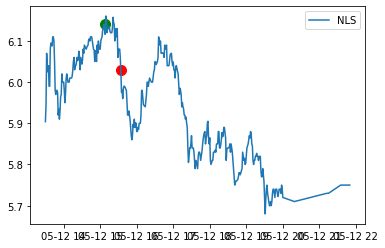

VOD analysis for run 552 with profit -99.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-15049.16,-15049.16,buy,2020-05-12 16:26:04.185381,15.14,[15.06],"[15.19, 15.195]",994,"{'avg': 14.9788, 'rsi': 62.214124048721786, 'macd': [0.002140873534070664, 0.0036311680177227856, 0.00332947659588001, 0.005049467913854855, 0.007536076861969221], 'vwap': 15.14, 'supports': [14.975, 15.06, 15.07, 15.12], 'sell_macd': [0.0017496392151272744, 0.0026952872350758383, 0.002467281961854084, 0.003556274191007347, 0.005137874964491473], 'slow macd': [0.006710983346742694, 0.006847696898326205, 0.006676240318796545, 0.006907657131762335, 0.007349424208175748], 'macd_signal': [-0.002849496363822636, -0.0015533634875135515, -0.0005767954708348392, 0.0005484572061030997, 0.001945981137276324], 'resistances': [15.19, 15.195], 'position_ratio': '2.5', 'sell_macd_signal': [-0.0015197911199771002, -0.0006767754489665124, -4.796396680239307e-05, 0.000672883664759555, 0.0015658819247059389]}",15.43,15.04
1,-99.40,14949.76,sell,2020-05-12 17:25:57.126082,15.04,None,None,994,"{'avg': 15.0025, 'rsi': [34.21578340734455, 21.752703806142716], 'vwap': 15.0469, 'reasons': 'stopped', 'movement': -0.0062747688243065146, 'sell_macd': [-0.004910996345119045, -0.005058287540963491, -0.005107367855375244, -0.005432529556795629, -0.007599765563657712], 'sell_macd_signal': [-0.0028791879922620265, -0.003315007902002319, -0.003673479892676904, -0.004025289825500649, -0.004740184973132062]}",15.43,15.04


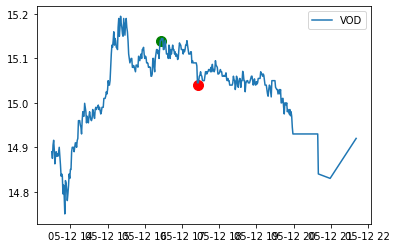

SAR analysis for run 552 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3003.0,-3003.0,buy,2020-05-12 15:59:20.135635,14.3,"[12.93, 12.93, 13.39, 13.61, 13.6895, 13.69, 13.95, 13.97]","[15.15, 15.19]",210,"{'avg': 13.7681, 'rsi': 68.80536103056959, 'macd': [0.08554959562419562, 0.08549508224298386, 0.07589459361390993, 0.08505780515963401, 0.09525624377626052], 'vwap': 14.3, 'supports': [12.8, 12.9201, 12.93, 12.935, 12.96, 12.985, 13.11, 13.39, 13.61, 13.6895, 13.69, 13.95, 13.97], 'sell_macd': [0.0499687832703426, 0.049885273673456965, 0.0435827301736289, 0.04953421926241752, 0.05612584427624867], 'slow macd': [0.10669661576950595, 0.10707687130078725, 0.10553455242524734, 0.10746537451948157, 0.1098695968868384], 'macd_signal': [0.07438261489204752, 0.07660510836223479, 0.07646300541256981, 0.07818196536198266, 0.08159682104483823], 'resistances': [14.605, 14.65, 14.8, 14.85, 15.15, 15.15, 15.19, 15.366, 15.44], 'position_ratio': '0.92', 'sell_macd_signal': [0.04261559134671641, 0.04406952781206452, 0.043972168284377396, 0.04508457847998542, 0.04729283163923807]}",15.65,13.85
1,0.0,3003.0,sell,2020-05-12 16:55:54.638071,14.3,None,None,210,"{'avg': 13.8768, 'rsi': [60.81792756856477, 57.1614213301786], 'vwap': 14.3395, 'reasons': 'bail', 'movement': 0.0027622377622376596, 'sell_macd': [0.03612423831139466, 0.03707719086404104, 0.0362992682964407, 0.03729959787627912, 0.03549076900503145], 'sell_macd_signal': [0.034309111555148764, 0.03486272741692722, 0.03515003559282991, 0.035579948049519756, 0.0355621122406221]}",15.65,13.85


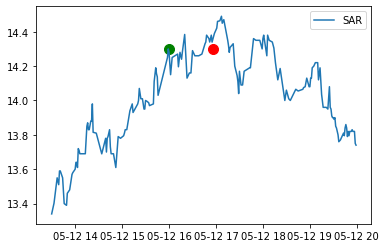

ALT analysis for run 552 with profit 14.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2708.16,-2708.16,buy,2020-05-12 15:35:14.290413,3.72,"[3.56, 3.6]","[3.7786, 3.8]",728,"{'avg': 3.5794, 'rsi': 63.22396715869297, 'macd': [0.012010652865816596, 0.013133736116328176, 0.013943744519249623, 0.01593513293157578, 0.018111461369362925], 'vwap': 3.7171, 'supports': [3.26, 3.2772, 3.56, 3.6, 3.6496], 'sell_macd': [0.00801567035052031, 0.008694664605333191, 0.009162781367455075, 0.010395563501998772, 0.01174064615876036], 'slow macd': [0.022231482022232463, 0.022219179768596664, 0.02218831843125546, 0.022428316347710364, 0.022773187175527898], 'macd_signal': [0.0014503481729366851, 0.0037870257616149836, 0.005818369513141911, 0.007841722196828684, 0.009895670031335532], 'resistances': [3.7786, 3.8], 'position_ratio': '0.83', 'sell_macd_signal': [0.0010273383409721653, 0.0025608035938443708, 0.0038811991485665116, 0.0051840720192529634, 0.006495386847154443]}",4.11,3.59
1,14.56,2722.72,sell,2020-05-12 19:45:16.368439,3.74,None,None,728,{'liquidation': 1},4.11,3.59


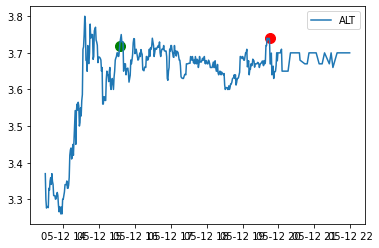

VEDL analysis for run 552 with profit 89.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4606.74,-4606.74,buy,2020-05-12 16:28:28.090176,5.13,"[5.06, 5.085]","[5.179, 5.3]",898,"{'avg': 5.0713, 'rsi': 66.09781627457987, 'macd': [4.9814448646934295e-05, 0.0037648505923799647, 0.006632587165477766, 0.008404943886104022, 0.009705736828063749], 'vwap': 5.1351, 'supports': [4.97, 5.06, 5.085], 'sell_macd': [0.0010373811028800972, 0.0034040977921758753, 0.005204083552767358, 0.0062793440992967575, 0.007040854342055702], 'slow macd': [-0.0021418160694564037, -0.001426299916979623, -0.0007657210019393901, -0.00023671061908725477, 0.0002519738005135608], 'macd_signal': [-0.008265516618916363, -0.005859443176657098, -0.003361037108230125, -0.0010078409093632955, 0.0011348746381221134], 'resistances': [5.179, 5.3], 'position_ratio': '0.88', 'sell_macd_signal': [-0.00434429174565523, -0.0027946138380890093, -0.0011948743599177357, 0.0002999693319251631, 0.001648146333951271]}",5.45,5.03
1,89.80,4696.54,sell,2020-05-12 16:49:26.658384,5.23,None,None,898,"{'avg': 5.075, 'rsi': [75.330832903581, 81.50563079656946], 'vwap': 5.2327, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0233918128654971, 'sell_macd': [0.015900056606541924, 0.016311198766196355, 0.01600415111441844, 0.01623237176089809, 0.018017577826194398], 'sell_macd_signal': [0.012876730688649862, 0.013563624304159161, 0.014051729666211018, 0.014487858085148433, 0.015193802033357625]}",5.45,5.03


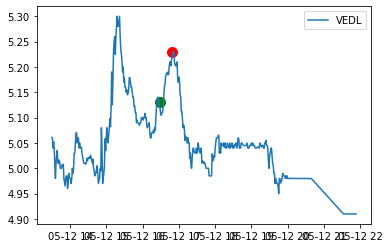

MGY analysis for run 552 with profit -98.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2261.88,-2261.88,buy,2020-05-12 14:32:08.630235,5.49,"[5.33, 5.35, 5.45]","[5.54, 5.62]",412,"{'avg': 5.4114, 'rsi': 59.55970238823301, 'macd': [-0.01729250804336946, -0.014783716238417455, -0.008661059226122703, -0.001372241803657026, 0.00515172901797456], 'vwap': 5.5, 'supports': [5.0, 5.03, 5.33, 5.45], 'sell_macd': [-0.012313606299780844, -0.010485184122199342, -0.006326865748471633, -0.0014460090189629682, 0.0028955158224590605], 'slow macd': [0.03273952514624057, 0.031769634542500924, 0.0316261732000882, 0.03192341060844761, 0.03230575752336229], 'macd_signal': [-0.016450981016089623, -0.01611752806055519, -0.014626234293668692, -0.011975435795666359, -0.008550002832938174], 'resistances': [5.54, 5.62], 'position_ratio': '0.8', 'sell_macd_signal': [-0.01274589682146406, -0.012293754281611117, -0.01110037657498322, -0.009169503063779168, -0.0067564992865315225]}",6.19,5.27
1,-98.88,2163.00,sell,2020-05-12 15:36:28.589043,5.25,None,None,412,"{'avg': 5.4062, 'rsi': [41.21374087289977, 37.82104795395396], 'vwap': 5.2785, 'reasons': 'stopped', 'movement': -0.04007285974499101, 'sell_macd': [-0.0014701224659212642, -0.0021571376832572042, -0.0029241997008799814, -0.00452289478343193, -0.0067488533570641], 'sell_macd_signal': [-0.004318615776644786, -0.00388632015796727, -0.003693896066549812, -0.0038596958099262357, -0.004437527319353808]}",6.19,5.27


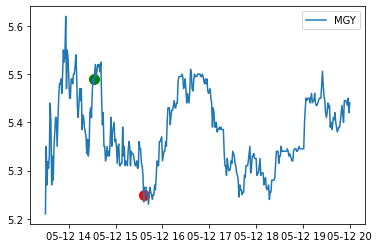

SSRM analysis for run 552 with profit 33.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12150.00,-12150.00,buy,2020-05-12 15:40:51.228168,18.00,"[17.725, 17.8002, 17.89]","[18.105, 18.14, 18.15]",675,"{'avg': 17.7034, 'rsi': 65.64697852790586, 'macd': [0.00729552834857472, 0.005724477587026655, 0.006821523542086538, 0.008401015118934652, 0.015126816039611413], 'vwap': 17.9998, 'supports': [17.48, 17.63, 17.65, 17.725, 17.8002, 17.89], 'sell_macd': [0.0029758556385104384, 0.0020291927258213605, 0.002823621719496572, 0.003925467406521221, 0.008369432001519073], 'slow macd': [0.03490673971400682, 0.03396441311139853, 0.03352292923893074, 0.03322307073932862, 0.034013607848269345], 'macd_signal': [0.013002012554989046, 0.011546505561396568, 0.010601509157534562, 0.01016141034981458, 0.011154491487773945], 'resistances': [18.105, 18.14, 18.15], 'position_ratio': '0.95', 'sell_macd_signal': [0.0064675597285976435, 0.005579886328042387, 0.005028633406333223, 0.004808000206370823, 0.005520286565400473]}",18.42,17.86
1,33.75,12183.75,sell,2020-05-12 16:24:05.643600,18.05,None,None,675,"{'avg': 17.7616, 'rsi': [53.51030561097737, 53.51030561097737], 'vwap': 18.05, 'reasons': 'bail', 'movement': 0.0027777777777778173, 'sell_macd': [0.021862473097495894, 0.01982432898394748, 0.02005662799957264, 0.0178992424533142, 0.015985705112679938], 'sell_macd_signal': [0.015658242839717406, 0.016491460068563422, 0.017204493654765264, 0.01734344341447505, 0.01707189575411603]}",18.42,17.86


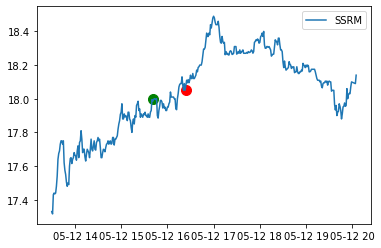

In [15]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))